# Influence Maximization on Facebook Network (Independent Cascade Model)
### Real-World Social Network Simulation (500 Nodes Sample)
This notebook demonstrates influence maximization using the **Independent Cascade (IC)** model on the real **Facebook Social Circles** dataset from the Stanford SNAP repository.

**Legend:**
- 🔴 Red → Seed nodes (initial influencers)
- 🟠 Orange → Activated (influenced) nodes
- ⚪ Gray → Unaffected nodes

In [ ]:
!pip install networkx matplotlib requests

## Step 1: Download and Load the Real Facebook Dataset

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import requests, gzip, shutil, random

# Download dataset from SNAP
url = 'https://snap.stanford.edu/data/facebook_combined.txt.gz'
file_path = 'facebook_combined.txt.gz'

r = requests.get(url, stream=True)
with open(file_path, 'wb') as f:
    shutil.copyfileobj(r.raw, f)

# Extract file
with gzip.open(file_path, 'rt') as f:
    G_full = nx.read_edgelist(f, nodetype=int)

print(f'Total nodes in full network: {G_full.number_of_nodes()}')
print(f'Total edges in full network: {G_full.number_of_edges()}')

Total nodes in full network: 4039
Total edges in full network: 88234


## Step 2: Sample 500 connected nodes for visualization

Graph after sampling: 150 nodes, 608 edges


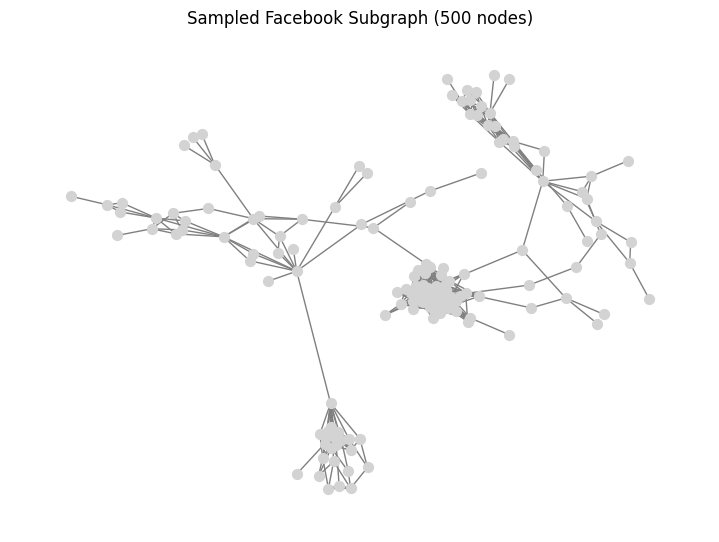

In [ ]:
random.seed(42)
nodes_sample = random.sample(list(G_full.nodes()), 500)
G = G_full.subgraph(nodes_sample).copy()

# Ensure connectivity by taking the largest connected component
G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
print(f'Graph after sampling: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges')

# Visualize sampled graph
plt.figure(figsize=(7,5))
nx.draw(G, node_color='lightgray', edge_color='gray', node_size=50)
plt.title('Sampled Facebook Subgraph (500 nodes)')
plt.show()

## Step 3: Define the Independent Cascade (IC) Model

In [ ]:
def independent_cascade(G, seeds, p=0.2, steps=5):
    active = set(seeds)
    newly_active = set(seeds)
    for _ in range(steps):
        next_active = set()
        for node in newly_active:
            for neighbor in G.neighbors(node):
                if neighbor not in active and random.random() < p:
                    next_active.add(neighbor)
        if not next_active:
            break
        active.update(next_active)
        newly_active = next_active
    return active

## Step 4: Define a Simple Greedy Seed Selection Function

In [ ]:
def greedy_seeds(G, k=5, p=0.2):
    seeds = []
    for _ in range(k):
        best_node, best_spread = None, 0
        for node in G.nodes():
            if node in seeds:
                continue
            spread = len(independent_cascade(G, seeds + [node], p))
            if spread > best_spread:
                best_spread = spread
                best_node = node
        seeds.append(best_node)
    return seeds

## Step 5: Run Simulation with Adjustable Parameters

In [ ]:
# User adjustable parameters
k = 5       # number of seed nodes
p = 0.25    # influence probability

seeds = greedy_seeds(G, k=k, p=p)
activated = independent_cascade(G, seeds, p=p)

print(f'Selected seeds: {seeds}')
print(f'Total activated nodes: {len(activated)}')
print(f'Influence spread: {100 * len(activated)/G.number_of_nodes():.2f}% of the network')

Selected seeds: [1175, 2985, 1494, 3891, 3250]
Total activated nodes: 75
Influence spread: 50.00% of the network


## Step 6: Visualize Influence Spread

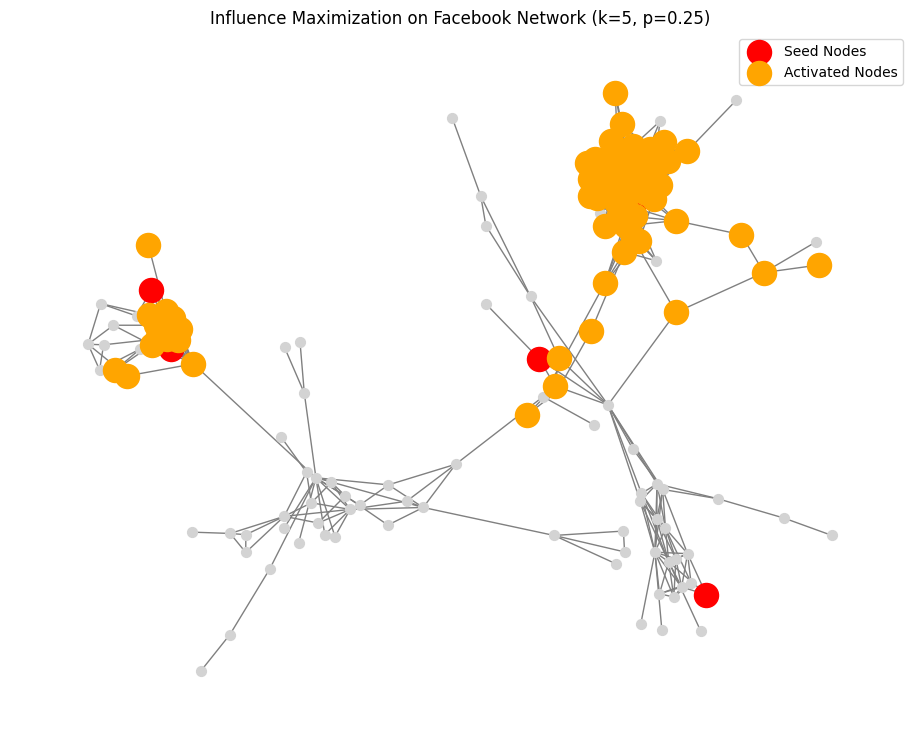

In [ ]:
plt.figure(figsize=(9,7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color='lightgray', edge_color='gray', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=seeds, node_color='red', label='Seed Nodes')
nx.draw_networkx_nodes(G, pos, nodelist=list(activated - set(seeds)), node_color='orange', label='Activated Nodes')
plt.title(f'Influence Maximization on Facebook Network (k={k}, p={p})')
plt.legend()
plt.show()

### ✅ Results Summary
This notebook loaded a real Facebook social network, selected seed nodes using a simple greedy IC-based approach, and visualized the diffusion spread. Adjust **k** and **p** to explore how the number of seeds and probability affect the size of the influenced population.

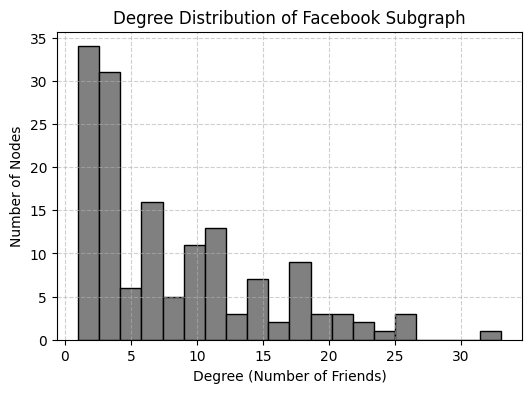

In [ ]:
import matplotlib.pyplot as plt

degrees = [d for n, d in G.degree()]
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=20, color='gray', edgecolor='black')
plt.title("Degree Distribution of Facebook Subgraph")
plt.xlabel("Degree (Number of Friends)")
plt.ylabel("Number of Nodes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


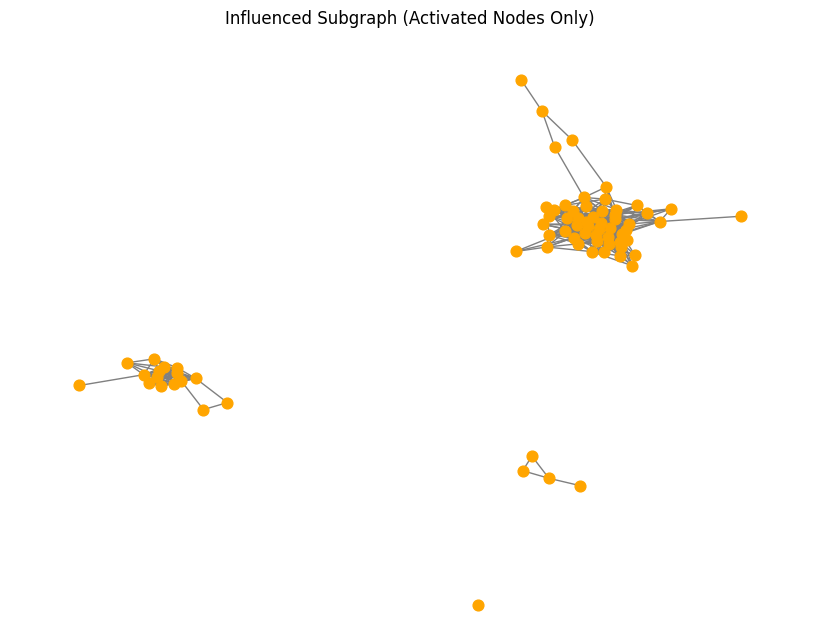

In [ ]:
# Extract subgraph of influenced nodes
G_influenced = G.subgraph(activated).copy()

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G_influenced, seed=42)
nx.draw(G_influenced, pos, node_color='orange', edge_color='gray', with_labels=False, node_size=60)
plt.title("Influenced Subgraph (Activated Nodes Only)")
plt.show()


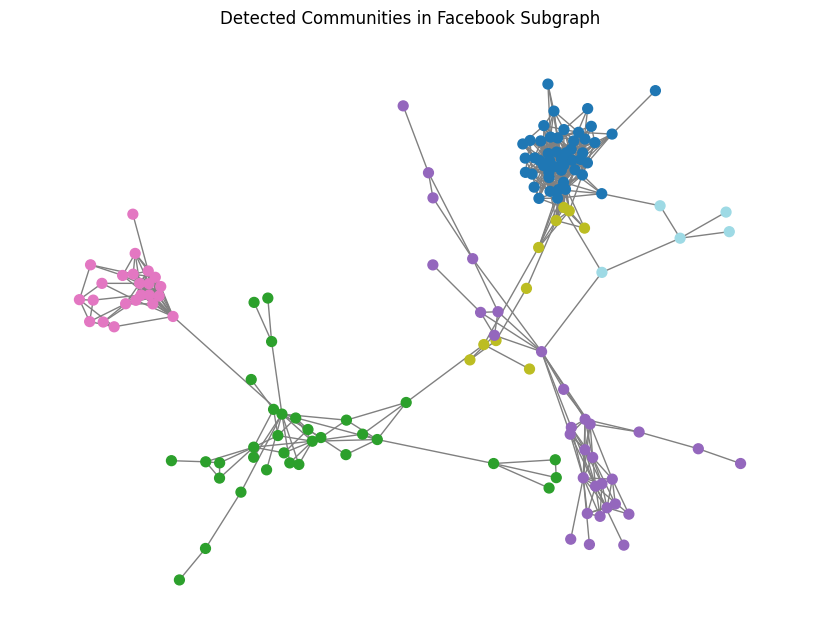

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
color_map = []
for node in G:
    for i, comm in enumerate(communities):
        if node in comm:
            color_map.append(i)
            break

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=color_map, cmap='tab20', node_size=50, edge_color='gray', with_labels=False)
plt.title("Detected Communities in Facebook Subgraph")
plt.show()


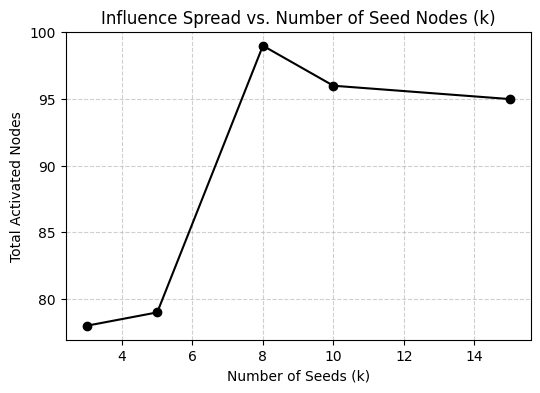

In [ ]:
results = []
for k_test in [3, 5, 8, 10, 15]:
    seeds_test = greedy_seeds(G, k=k_test, p=0.25)
    activated_test = independent_cascade(G, seeds_test, p=0.25)
    results.append((k_test, len(activated_test)))

# Plot
ks, spreads = zip(*results)
plt.figure(figsize=(6,4))
plt.plot(ks, spreads, marker='o', color='black')
plt.title("Influence Spread vs. Number of Seed Nodes (k)")
plt.xlabel("Number of Seeds (k)")
plt.ylabel("Total Activated Nodes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


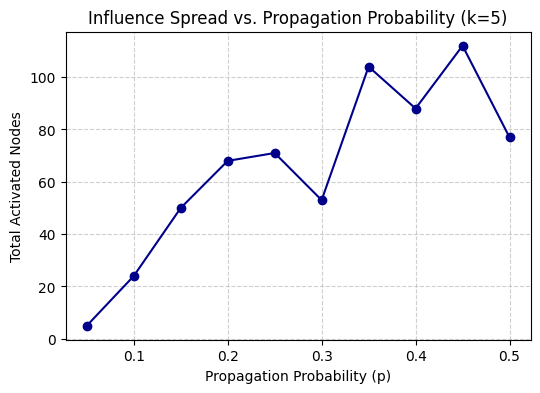

In [ ]:
import numpy as np

k_val = 5
p_values = np.linspace(0.05, 0.5, 10)
spread_values = []

for p_val in p_values:
    seeds_test = greedy_seeds(G, k=k_val, p=p_val)
    activated_test = independent_cascade(G, seeds_test, p=p_val)
    spread_values.append(len(activated_test))

plt.figure(figsize=(6,4))
plt.plot(p_values, spread_values, marker='o', color='darkblue')
plt.title(f"Influence Spread vs. Propagation Probability (k={k_val})")
plt.xlabel("Propagation Probability (p)")
plt.ylabel("Total Activated Nodes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


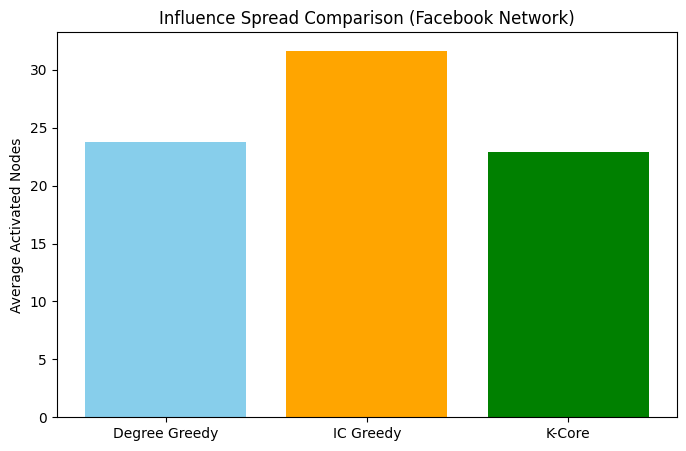

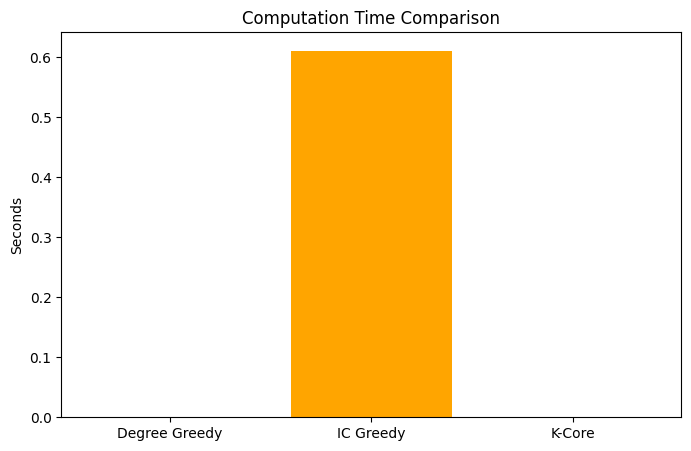

===== Influence Spread Results =====
Degree Greedy  : 23.75 nodes activated (avg)
IC Greedy      : 31.65 nodes activated (avg)
K-Core         : 22.90 nodes activated (avg)

===== Runtime (seconds) =====
Degree Greedy  : 0.001s
IC Greedy      : 0.611s
K-Core         : 0.001s


In [ ]:
# ============================================
# INFLUENCE COMPARISON: K-Core vs Degree Greedy vs IC Greedy
# ============================================

import numpy as np
import time

# -----------------------------
# 1️⃣ Independent Cascade (IC) Model
# -----------------------------
def independent_cascade(G, seeds, p=0.1, steps=10):
    active = set(seeds)
    newly_active = set(seeds)
    for _ in range(steps):
        next_active = set()
        for node in newly_active:
            for nbr in G.neighbors(node):
                if nbr not in active and random.random() < p:
                    next_active.add(nbr)
        if not next_active:
            break
        active |= next_active
        newly_active = next_active
    return len(active)

# -----------------------------
# 2️⃣ Greedy (Degree-Based) Approach
# -----------------------------
def degree_greedy(G, k):
    return [n for n, _ in sorted(G.degree, key=lambda x: x[1], reverse=True)[:k]]

# -----------------------------
# 3️⃣ K-Core-Based Selection
# -----------------------------
def kcore_selection(G, k):
    core_number = nx.core_number(G)
    max_core = max(core_number.values())
    candidates = [n for n, c in core_number.items() if c == max_core]
    if len(candidates) > k:
        deg = dict(G.degree(candidates))
        return sorted(deg, key=deg.get, reverse=True)[:k]
    return candidates

# -----------------------------
# 4️⃣ IC Greedy Approximation (simulation-based)
# -----------------------------
def ic_greedy(G, k, p=0.1, simulations=5):
    selected = []
    for _ in range(k):
        spread = {}
        for node in set(G.nodes()) - set(selected):
            influence = np.mean([independent_cascade(G, selected + [node], p) for _ in range(simulations)])
            spread[node] = influence
        best = max(spread, key=spread.get)
        selected.append(best)
    return selected

# -----------------------------
# 5️⃣ Comparison Setup
# -----------------------------
k = 10        # Number of seed influencers
p = 0.1       # Activation probability
simulations = 10

methods = {}
timing = {}

# Degree Greedy
start = time.time()
deg_nodes = degree_greedy(G, k)
timing["Degree Greedy"] = time.time() - start
methods["Degree Greedy"] = deg_nodes

# IC Greedy
start = time.time()
ic_nodes = ic_greedy(G, k, p, simulations)
timing["IC Greedy"] = time.time() - start
methods["IC Greedy"] = ic_nodes

# K-Core
start = time.time()
kc_nodes = kcore_selection(G, k)
timing["K-Core"] = time.time() - start
methods["K-Core"] = kc_nodes

# -----------------------------
# 6️⃣ Evaluate Influence Spread
# -----------------------------
results = {}
for name, seeds in methods.items():
    spread = np.mean([independent_cascade(G, seeds, p) for _ in range(20)])
    results[name] = spread

# -----------------------------
# 7️⃣ Visualization
# -----------------------------
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color=['skyblue','orange','green'])
plt.title("Influence Spread Comparison (Facebook Network)")
plt.ylabel("Average Activated Nodes")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(timing.keys(), timing.values(), color=['skyblue','orange','green'])
plt.title("Computation Time Comparison")
plt.ylabel("Seconds")
plt.show()

# -----------------------------
# 8️⃣ Print Final Results
# -----------------------------
print("===== Influence Spread Results =====")
for name, val in results.items():
    print(f"{name:<15}: {val:.2f} nodes activated (avg)")

print("\n===== Runtime (seconds) =====")
for name, val in timing.items():
    print(f"{name:<15}: {val:.3f}s")


Extracting graph...
✅ Total nodes: 4039
✅ Total edges: 88234
Using subgraph with 141 nodes for visualization.

Maximum core number in this graph: 9


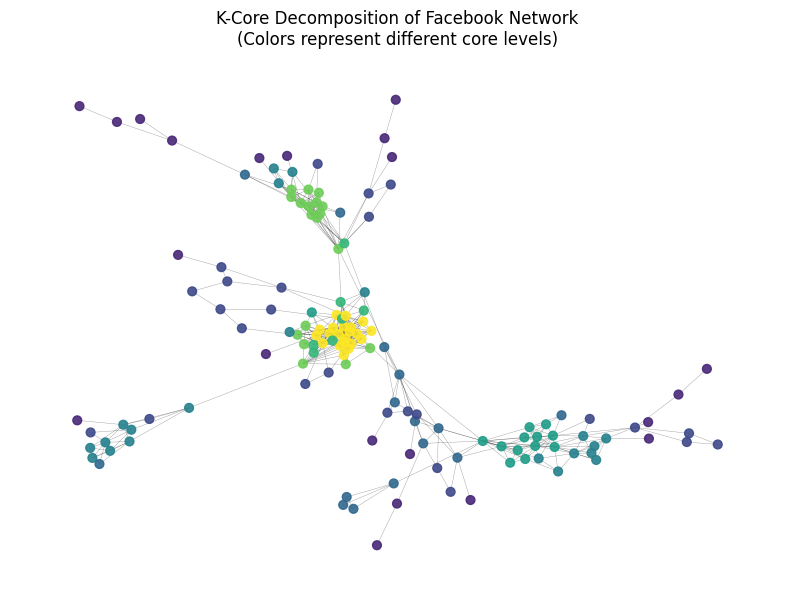


Available core levels: [1, 2, 3, 4, 5, 6, 7, 9]
Visualizing 5-core: 59 nodes, 314 edges


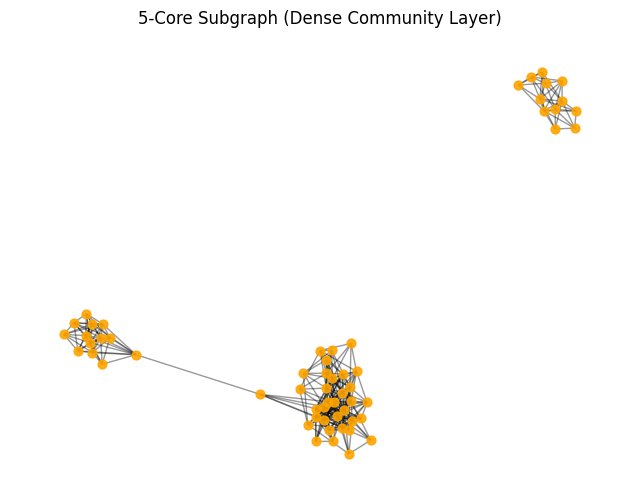

Visualizing 6-core: 46 nodes, 269 edges


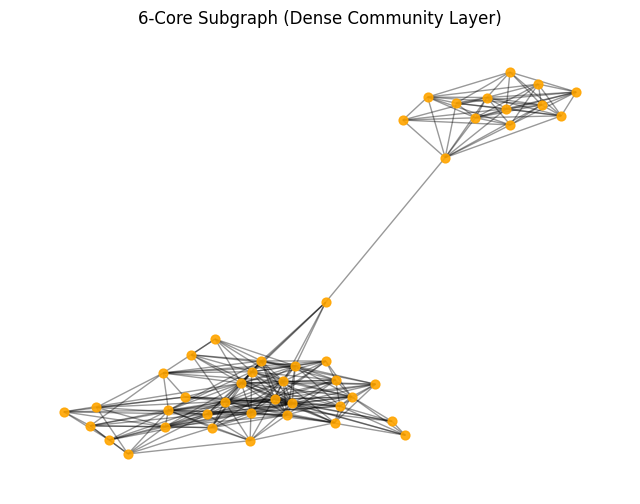

Visualizing 7-core: 39 nodes, 228 edges


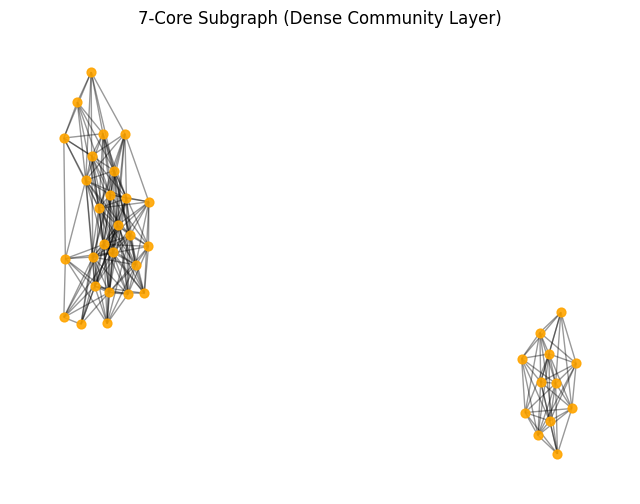

Visualizing 9-core: 21 nodes, 137 edges


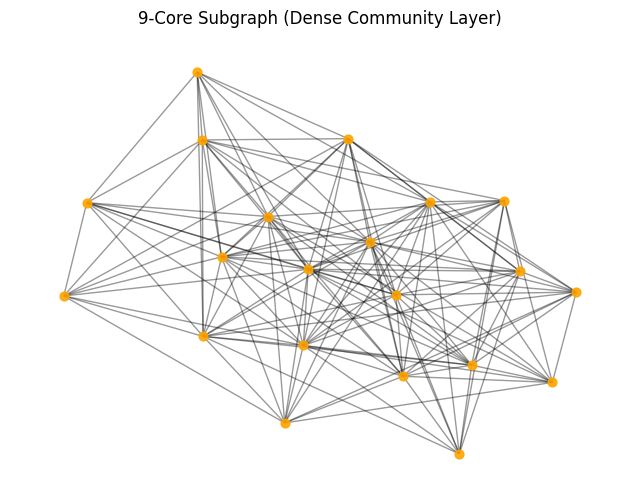

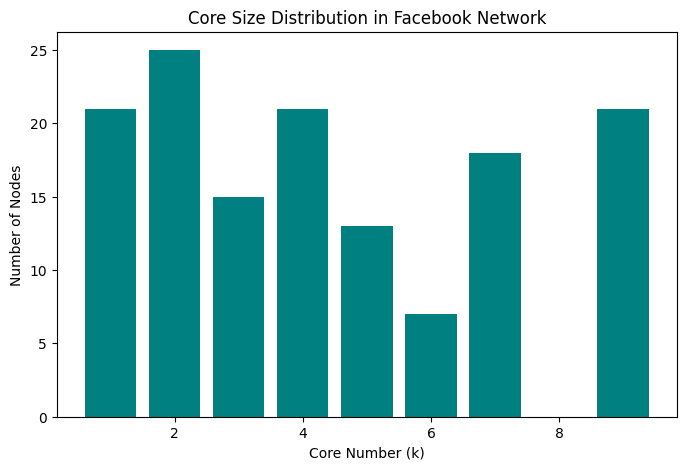

In [ ]:
# ============================================
# FACEBOOK NETWORK - K-CORE COMMUNITY ANALYSIS (Fixed)
# ============================================

import networkx as nx
import matplotlib.pyplot as plt
import requests, gzip, shutil, random
from itertools import cycle

# -----------------------------
# 1️⃣ Download and Load Dataset
# -----------------------------
url = 'https://snap.stanford.edu/data/facebook_combined.txt.gz'
file_path = 'facebook_combined.txt.gz'

print("Downloading Facebook dataset...")
r = requests.get(url, stream=True)
with open(file_path, 'wb') as f:
    shutil.copyfileobj(r.raw, f)

print("Extracting graph...")
with gzip.open(file_path, 'rt') as f:
    G_full = nx.read_edgelist(f, nodetype=int)

print(f"✅ Total nodes: {G_full.number_of_nodes()}")
print(f"✅ Total edges: {G_full.number_of_edges()}")

# -----------------------------
# 2️⃣ Take a smaller connected subgraph for visualization
# -----------------------------
# Convert NodeView to list before sampling
sample_nodes = random.sample(list(G_full.nodes()), 500)
G_sub = G_full.subgraph(sample_nodes).copy()

# Keep the largest connected component
largest_cc = max(nx.connected_components(G_sub), key=len)
G = G_sub.subgraph(largest_cc).copy()

print(f"Using subgraph with {G.number_of_nodes()} nodes for visualization.\n")

# -----------------------------
# 3️⃣ Compute K-Core Decomposition
# -----------------------------
core_number = nx.core_number(G)
max_core = max(core_number.values())
print(f"Maximum core number in this graph: {max_core}")

# -----------------------------
# 4️⃣ Visualize Core Layers (Communities)
# -----------------------------
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)

# Assign colors by core number
colors = plt.cm.viridis([core_number[n] / max_core for n in G.nodes()])

nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.4)
plt.title("K-Core Decomposition of Facebook Network\n(Colors represent different core levels)")
plt.axis("off")
plt.show()

# -----------------------------
# 5️⃣ Show Subgraphs for Higher K Values
# -----------------------------
ks = sorted(set(core_number.values()))
print(f"\nAvailable core levels: {ks}")

for k in ks[-4:]:  # Show top 4 core levels
    kcore_subgraph = nx.k_core(G, k)
    print(f"Visualizing {k}-core: {kcore_subgraph.number_of_nodes()} nodes, {kcore_subgraph.number_of_edges()} edges")

    plt.figure(figsize=(8, 6))
    pos_sub = nx.spring_layout(kcore_subgraph, seed=42)
    nx.draw_networkx_nodes(kcore_subgraph, pos_sub, node_color='orange', node_size=40, alpha=0.9)
    nx.draw_networkx_edges(kcore_subgraph, pos_sub, alpha=0.4)
    plt.title(f"{k}-Core Subgraph (Dense Community Layer)")
    plt.axis("off")
    plt.show()

# -----------------------------
# 6️⃣ Core Size Distribution
# -----------------------------
core_sizes = [list(core_number.values()).count(k) for k in ks]
plt.figure(figsize=(8,5))
plt.bar(ks, core_sizes, color="teal")
plt.title("Core Size Distribution in Facebook Network")
plt.xlabel("Core Number (k)")
plt.ylabel("Number of Nodes")
plt.show()
